In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from glob import glob
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max
from keras_unet_collection import models, base, utils

2023-04-17 22:53:25.664649: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import time
import sys
sys.path.insert(0,'../..')
from gp2 import Runner

2023-04-17 22:53:27.942839: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-17 22:53:28.101680: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-17 22:53:28.101751: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-17 22:53:28.105726: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-17 22:53:28.105769: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-04-17 22:53:28.106812: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

In [10]:
R = Runner(verbose=True, classifier='kunet2d')

*** GP2 ***
Working directory: /tmp/tmpb_p8u2x6GP2
Verbose mode active!
Model: "unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
unet_down0_0 (Conv2D)           (None, 512, 512, 32) 288         input_3[0][0]                    
__________________________________________________________________________________________________
unet_down0_0_bn (BatchNormaliza (None, 512, 512, 32) 128         unet_down0_0[0][0]               
__________________________________________________________________________________________________
unet_down0_0_activation (ReLU)  (None, 512, 512, 32) 0           unet_down0_0_bn[0][0]            
_________________

In [11]:
# load our larger toy dataset (10k images and masks)
images = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/images.npy')
masks = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/masks.npy')

In [12]:
images.shape

(10000, 512, 512, 1)

In [13]:
masks.shape

(10000, 512, 512, 1)

In [14]:
print(images.max())

255


In [15]:
print(images.min())

0


In [16]:
print(masks.max())

True


In [17]:
weights = {
    'A': 0.5,
    'A_train': 0.1,
    'A_val': 0.3,
    'A_test': 0.6,
    'B': 0.3,
    'B_train': 0.7,
    'B_val': 0.1,
    'B_test': 0.2,
    'Z': 0.2
}
PERCENT_TO_REPLACE = 30

In [18]:
R.setup_data(images, masks, dataset_size=10000, weights=weights)

Weights OK!


In [19]:
RUNS = 5

In [ ]:
for run in range(RUNS):
    print('***')
    print('RUN:', run)
    t0 = time.time()
    R.run_classifier()
    R.run_discriminator()
    l = R.find_machine_labels()
    if l == 0:
        print('No more machine labels.')
        print('TOOK', time.time()-t0, 'seconds')
        break
    R.relabel(percent_to_replace=PERCENT_TO_REPLACE)
    print('TOOK', time.time()-t0, 'seconds')
    

***
RUN: 0


2023-04-17 23:09:57.048085: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-17 23:09:57.067012: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245755000 Hz


Epoch 1/100


2023-04-17 23:10:00.361613: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-17 23:10:01.090088: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-17 23:10:01.860891: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-17 23:10:01.860915: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-17 23:10:01.860972: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-17 23:10:01.881506: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-17 23:10:02.802781: I tensorflow/stream_exec

8/8 [==============================] - 91s 7s/step - loss: 0.5349 - dice_coef: 0.1632 - val_loss: 0.6918 - val_dice_coef: 0.0959


2023-04-17 23:11:31.358606: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
8/8 [==============================] - 10s 1s/step - loss: 0.5351 - dice_coef: 0.1630 - val_loss: 0.6785 - val_dice_coef: 0.1095
Epoch 3/100
8/8 [==============================] - 10s 1s/step - loss: 0.5351 - dice_coef: 0.1631 - val_loss: 0.6695 - val_dice_coef: 0.1164
Model saved to: /tmp/tmpb_p8u2x6GP2/kunet2d_0kunet2d_model
History saved to: /tmp/tmpb_p8u2x6GP2/kunet2d_history_0.pkl
Testing the classifier...


In [15]:
R.classifier_scores

[344.25732421875,
 348.4939880371094,
 346.9913330078125,
 347.586669921875,
 347.3193359375]

In [16]:
R.discriminator_scores

[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]

In [17]:
R.plot()

TypeError: 'float' object is not subscriptable

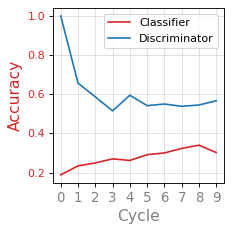

In [18]:
R.plot()

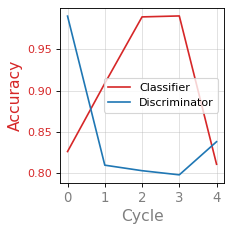

In [17]:
R.plot()